Ouvrir ce notebook dans :
<a href="https://colab.research.google.com/github/joanglaunes/deep_learning_image/blob/main/Mnist-denoising.ipynb" target="_blank">Google Colab</a>
ou
<a href="https://rosenblatt.ens.math-info.univ-paris5.fr/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2Fjoanglaunes%2Fdeep_learning_image&urlpath=tree%2Fdeep_learning_image%2FMnist-denoising.ipynb&branch=main" target="_blank">Rosenblatt</a>

Exemple de réseau convolutionnel simple pour le denoising.

Cet exemple est censé être lu après avoir lu l'exemple "mnist", dont il est directement dérivé. Seuls les parties différentes sont commentées.

<br>
<br>
<br>
Imports des librairies, paramètres généraux et définition du jeu de données. Cette partie est quasi inchangée, seul le paramètre num_classes est supprimé ici, car on ne se trouve plus dans un problème de classification (les classes ne joueront aucun rôle).

In [15]:
#imports
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import math
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device:", device)

# Hyper parameters
num_epochs = 1
batch_size = 16
learning_rate = 0.001 #0.0001

device: cpu


In [16]:
# dataset d'images
dataset = "MNIST" # "FER2013" # "CIFAR10" # "Imagenette" #

if dataset == "MNIST":
    train_dataset = torchvision.datasets.MNIST(root='data/', train=True,
                                              transform=transforms.ToTensor(),
                                              download=True)
    test_dataset = torchvision.datasets.MNIST(root='data/', train=False,
                                             transform=transforms.ToTensor(),
                                             download=True)
    n_channels = 1
elif dataset == "CIFAR10":
    train_dataset = torchvision.datasets.CIFAR10(root='data/', train=True,
                                              transform=transforms.ToTensor(),
                                              download=True)
    test_dataset = torchvision.datasets.CIFAR10(root='data/', train=False,
                                             transform=transforms.ToTensor(),
                                             download=True)
    n_channels = 3
elif dataset == "FER2013":
    train_dataset = torchvision.datasets.FER2013(root='data/', split="train",
                                              transform=transforms.ToTensor())
    test_dataset = torchvision.datasets.FER2013(root='data/', split="test",
                                             transform=transforms.ToTensor())
    n_channels = 1
elif dataset == "Imagenette":
    transform=transforms.Compose([transforms.ToTensor(),
                                transforms.RandomCrop(size=(20,32),pad_if_needed=True)])
    train_dataset = torchvision.datasets.Imagenette(root='data/', split="train",
                                                   transform=transform,
                                                   download=True)
    test_dataset = torchvision.datasets.Imagenette(root='data/', split="val",
                                                  transform=transform,
                                                  download=True)
    n_channels = 3

100%|██████████| 9.91M/9.91M [00:00<00:00, 129MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 30.6MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 109MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.94MB/s]


In [17]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

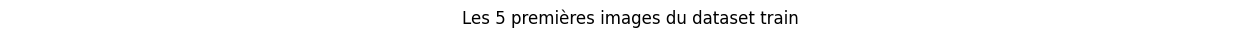

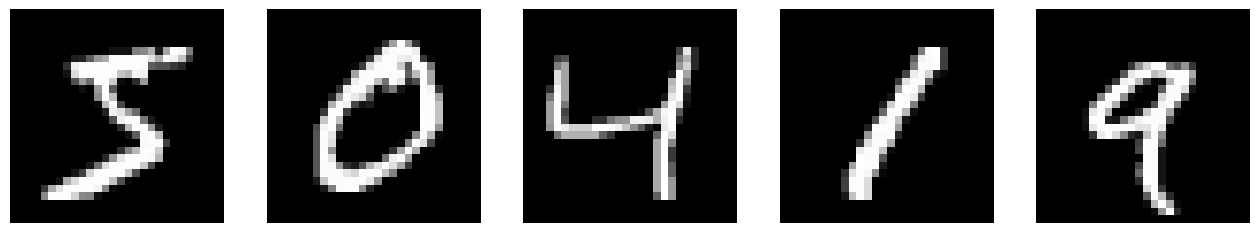

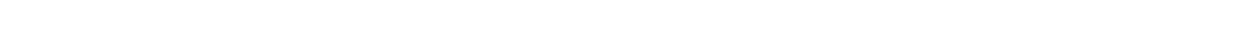

In [18]:
# affichage de quelques images
def show_images(images, nrows=1, title=None):
    nb_ims = images.shape[0]
    plt.figure(figsize=(plt.rcParams['figure.figsize'][0],0.1))
    plt.axis("off")
    plt.title(title)
    plt.show()
    ncols = math.ceil(nb_ims/nrows)
    for k in range(nb_ims):
       plt.subplot(nrows, ncols, k+1)
       plt.imshow(images[k].permute((1,2,0)), cmap="gray")
       plt.axis("off")
    plt.show()
    plt.figure(figsize=(plt.rcParams['figure.figsize'][0],0.3))
    plt.axis("off")
    plt.show()

def load_batch(dataset, n):
  return torch.stack([dataset[k][0] for k in range(n)])

train_images_sample = load_batch(train_dataset, 5)
show_images(train_images_sample, title="Les 5 premières images du dataset train")

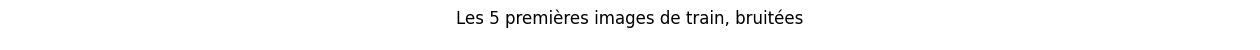

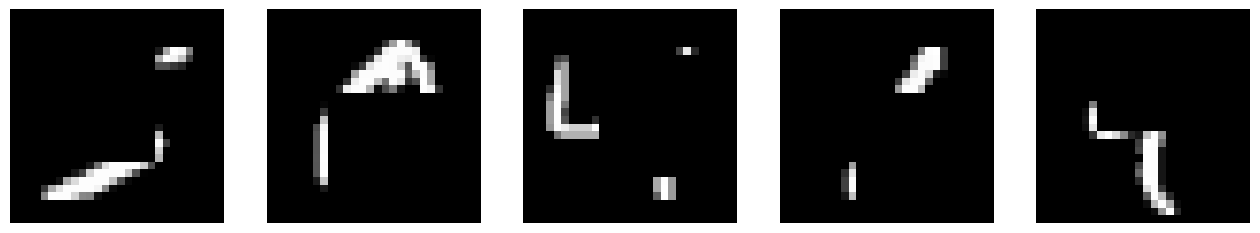

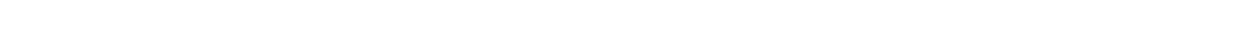

In [23]:
# une fonction pour ajouter du bruit
def salt_and_pepper(images,prob=.1):
    images_noisy = images.clone().permute((0,2,3,1))
    rnd = torch.rand(images_noisy.shape[:-1])
    images_noisy[rnd<prob,:] = 0
    images_noisy[rnd>1-prob,:] = 1
    return images_noisy.permute((0,3,1,2))

def random_remove(images, size=(16,16)):
    images_out = images.clone().permute((0,2,3,1))
    i = torch.randint(images_out.shape[1]-size[0], (images_out.shape[0],))
    j = torch.randint(images_out.shape[2]-size[0], (images_out.shape[0],))
    for k in range(images_out.shape[0]):
        images_out[k,i[k]:(i[k]+size[0]),j[k]:(j[k]+size[1]),:] = 0
    return images_out.permute((0,3,1,2))

corrupt_fun = random_remove

train_images_sample_noisy = corrupt_fun(train_images_sample)
show_images(train_images_sample_noisy, title="Les 5 premières images de train, bruitées")

<br>
<br>
<br>
Définition du réseau.

In [24]:
# Réseau CNN
class ConvNet(nn.Module):
    def __init__(self, n_channels):
        super(ConvNet, self).__init__()
        self.op = nn.Sequential(
            nn.Conv2d(n_channels, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2, stride=2))

            nn.Conv2d(32, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.Conv2d(16, n_channels, kernel_size=5, stride=1, padding=2),
            #nn.BatchNorm2d(n_channels),
            #nn.ReLU(),

            nn.Sigmoid()
        )

    def forward(self, x):
        # encoding
        out = self.op(x)
        return out

model = ConvNet(n_channels).to(device)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

<br>
<br>
<br>
Entraînement du réseau. Ici la seule mais fondamentale différence est que la fonction coût évalue la différence
entre la sortie du réseau et les images d''entrée, et non plus entre la sortie et les classes.
Ici le critère utilisé est celui des moindres carrés.

beginning training...
Epoch [1/1], Step [100/3750], Loss: 0.1977
Epoch [1/1], Step [200/3750], Loss: 0.1835
Epoch [1/1], Step [300/3750], Loss: 0.1759
Epoch [1/1], Step [400/3750], Loss: 0.1751
Epoch [1/1], Step [500/3750], Loss: 0.1758
Epoch [1/1], Step [600/3750], Loss: 0.1626
Epoch [1/1], Step [700/3750], Loss: 0.1533
Epoch [1/1], Step [800/3750], Loss: 0.1757
Epoch [1/1], Step [900/3750], Loss: 0.1599
Epoch [1/1], Step [1000/3750], Loss: 0.1765
Epoch [1/1], Step [1100/3750], Loss: 0.1749
Epoch [1/1], Step [1200/3750], Loss: 0.1674
Epoch [1/1], Step [1300/3750], Loss: 0.1456
Epoch [1/1], Step [1400/3750], Loss: 0.1826
Epoch [1/1], Step [1500/3750], Loss: 0.1552
Epoch [1/1], Step [1600/3750], Loss: 0.1735
Epoch [1/1], Step [1700/3750], Loss: 0.1615
Epoch [1/1], Step [1800/3750], Loss: 0.1578
Epoch [1/1], Step [1900/3750], Loss: 0.1595
Epoch [1/1], Step [2000/3750], Loss: 0.1598
Epoch [1/1], Step [2100/3750], Loss: 0.1680
Epoch [1/1], Step [2200/3750], Loss: 0.1631
Epoch [1/1], Step [

Text(0.5, 1.0, 'loss vs iterations')

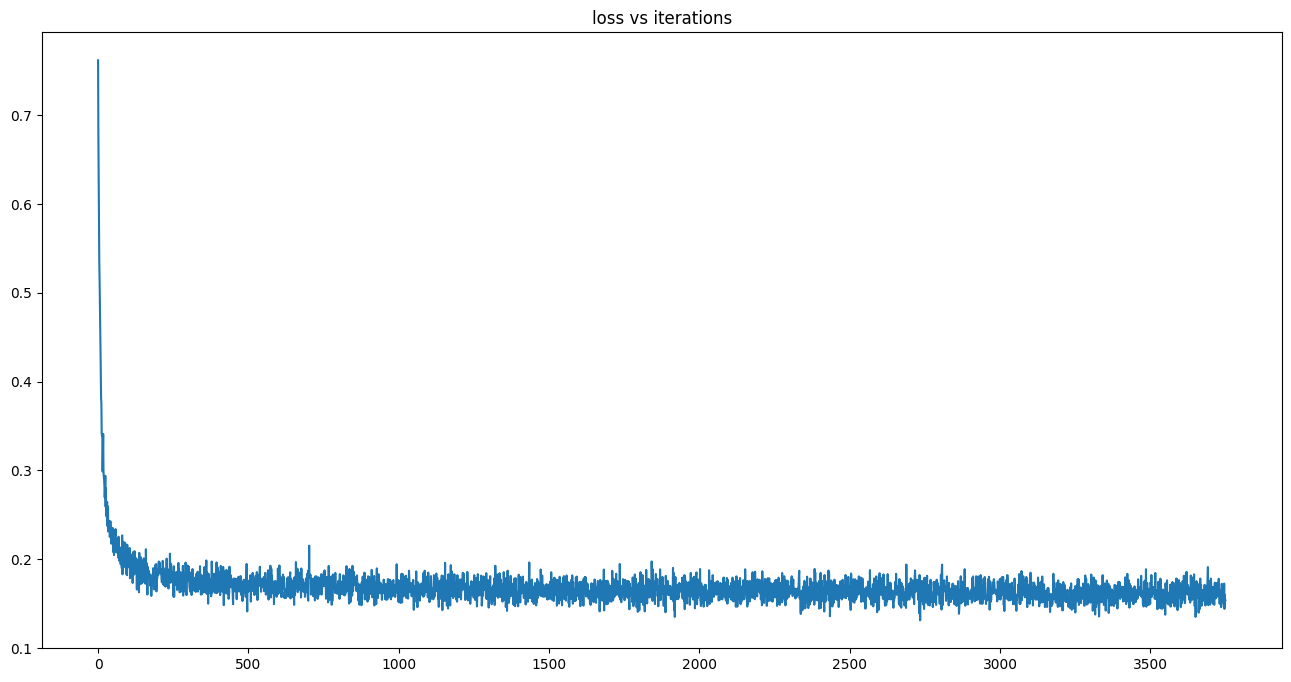

In [25]:
# Entraînement du réseau
lossfun = nn.BCELoss()
print("beginning training...")
total_step = len(train_loader)
rec_loss = np.zeros((num_epochs,len(train_loader)))
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        images = images.to(device)
        images_noisy = corrupt_fun(images)

        # Forward pass
        outputs = model(images_noisy)
        loss = lossfun(outputs,images)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        rec_loss[epoch,i] = loss.item()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
print("training done")
plt.plot(rec_loss.flatten())
plt.title("loss vs iterations")

<br>
<br>
<br>
On affiche la sortie du réseau pour cinq images test. Ces sorties sont censées être des images très proches des images d'entrée car le réseau a été entraîné pour ça.

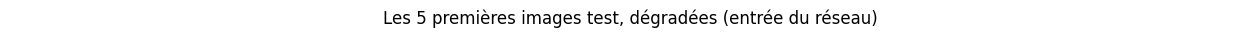

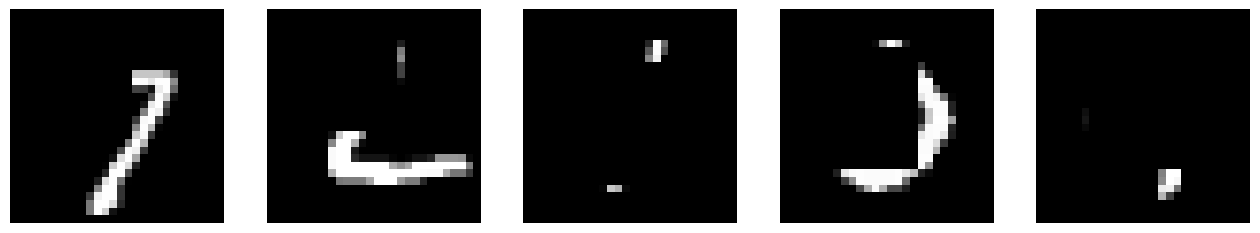

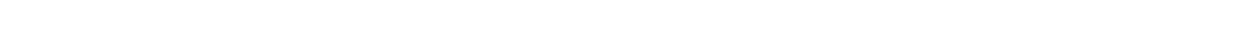

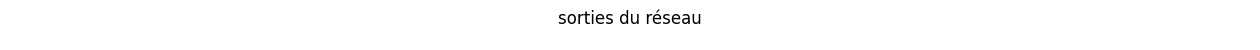

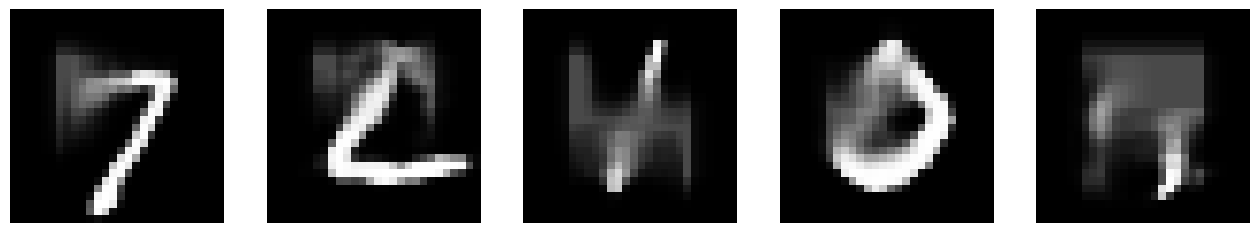

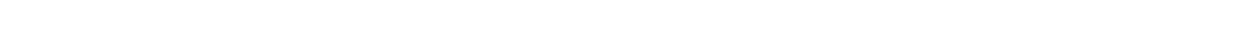

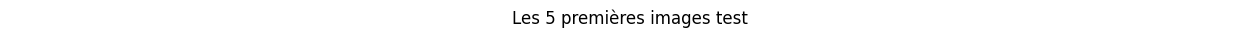

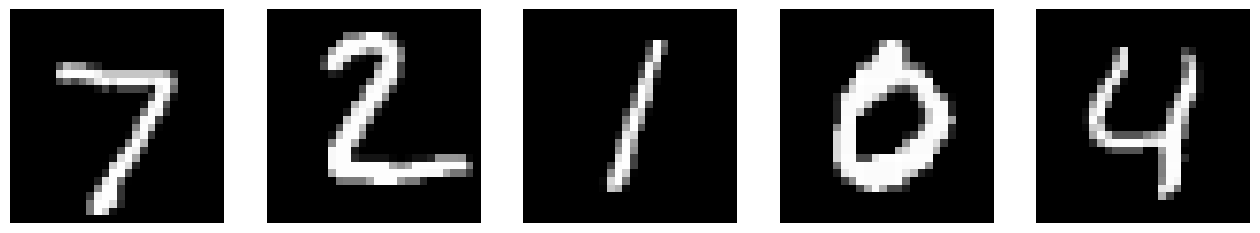

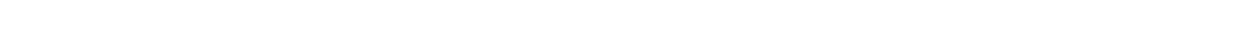

In [26]:
test_images_sample = load_batch(test_dataset, 5)
test_images_sample_corrupt = corrupt_fun(test_images_sample)

outputs = model(test_images_sample_corrupt.to(device)).detach().cpu()

show_images(test_images_sample_corrupt, title="Les 5 premières images test, dégradées (entrée du réseau)")
show_images(outputs, title="sorties du réseau")
show_images(test_images_sample, title="Les 5 premières images test")